In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
from matplotlib import pyplot


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.cluster import KMeans

from scipy.optimize import minimize, LinearConstraint #for optimization





In [3]:
#read in the pre-processed training and test set from Dmitri's notebook
X_train = pd.read_csv("data/X_train_random_1592420882.csv")
Y_train = pd.read_csv("data/Y_train_random_1592420882.csv")
X_test = pd.read_csv("data/X_test_random_1592420882.csv")
Y_test = pd.read_csv("data/Y_test_random_1592420882.csv")

In [4]:
assert((X_train.shape[0] == Y_train.shape[0]) & (X_test.shape[0] == Y_test.shape[0]))

In [5]:
print(f'Dim of X_train: {X_train.shape}')
print(f'Dim of Y_train: {Y_train.shape}')
print("\n")
print(f'Dim of X_test: {X_test.shape}')
print(f'Dim of Y_test: {Y_test.shape}')

Dim of X_train: (1076080, 37)
Dim of Y_train: (1076080, 2)


Dim of X_test: (269020, 37)
Dim of Y_test: (269020, 2)


In [6]:
print(f'Train-test split: [{X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])},\
{X_test.shape[0]/(X_train.shape[0] + X_test.shape[0])}]')

Train-test split: [0.8,0.2]


In [7]:
X_train.columns

Index(['id', 'application_type', 'grade', 'sub_grade', 'term',
       'initial_list_status', 'emp_length', 'verification_status', '_has_desc',
       'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'fico_range_low',
       'delinq_2yrs', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       '_credit_hist', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

In [11]:
X_train.dtypes

id                              int64
application_type                int64
grade                           int64
sub_grade                       int64
term                            int64
initial_list_status             int64
emp_length                      int64
verification_status             int64
_has_desc                       int64
loan_amnt                     float64
int_rate                      float64
installment                   float64
annual_inc                    float64
fico_range_low                float64
delinq_2yrs                   float64
dti                           float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
_credit_hist                  float64
purpose_credit_card             int64
purpose_debt_consolidation      int64
purpose_educational             int64
purpose_home_improvement        int64
purpose_house                   int64
purpose_majo

In [12]:
dtypes_map={
'id':'uint32',
'application_type':'uint8',
'grade':'uint8',
'sub_grade':'uint8',
'term':'uint8',
'initial_list_status':'uint8',
'emp_length':'uint8',
'verification_status':'uint8',
'_has_desc':'uint8',
'purpose_credit_card':'uint8',
'purpose_debt_consolidation':'uint8',
'purpose_educational':'uint8',
'purpose_home_improvement':'uint8',
'purpose_house':'uint8',
'purpose_major_purchase':'uint8',
'purpose_medical':'uint8',
'purpose_moving':'uint8',
'purpose_other':'uint8',
'purpose_renewable_energy':'uint8',
'purpose_small_business':'uint8',
'purpose_vacation':'uint8',
'purpose_wedding':'uint8',
'home_ownership_OTHER':'uint8',
'home_ownership_OWN':'uint8',
'home_ownership_RENT':'uint8'
}

In [14]:
X_train = X_train.astype(dtype=dtypes_map)
X_test = X_test.astype(dtype=dtypes_map)


In [15]:
np.mean(Y_train.id == X_train.id)

1.0

In [16]:
np.mean(Y_test.id == X_test.id)

1.0

In [17]:
##we need to get fields needed for return calculations.
LC_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
ret_df = LC_df[["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt", "recoveries"]].copy()

In [19]:
ret_df.term.value_counts(dropna=False)

 36 months    1609754
 60 months     650914
NaN                33
Name: term, dtype: int64

In [20]:
ret_df.dropna(subset=["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt"], inplace=True)

In [21]:
#convert term field to integer months
ret_df['term'] = ret_df['term'].apply(lambda t: np.int8(t.split()[0]))
ret_df.term.value_counts()


36    1607966
60     650275
Name: term, dtype: int64

In [22]:
ret_df[["total_pymnt", "funded_amnt", "recoveries"]].describe().T

,count,mean,std,min,25%,50%,75%,max
total_pymnt,2258241.0,12094.073850,9900.144164,10.0,4560.85,9343.69,16951.677553,63296.877917
funded_amnt,2258241.0,15041.772723,9186.916012,500.0,8000.00,12875.00,20000.000000,40000.000000
recoveries,2258241.0,142.565584,743.233625,0.0,0.00,0.00,0.000000,39859.550000


In [23]:
#convert issue_d and last_pymnt_d into datetime
ret_df['issue_d'] = ret_df['issue_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())
ret_df['last_pymnt_d'] = ret_df['last_pymnt_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())

In [24]:
#calculate the realized term of the loan in months. 
ret_df['realized_loan_term_mths'] = round((ret_df['last_pymnt_d'] - ret_df['issue_d'])/np.timedelta64(1, 'M'))

In [25]:
#where realized_loan_term_mths != term means default or pre-payment
np.sum(ret_df.realized_loan_term_mths != ret_df.term)/ret_df.shape[0]

0.9240351229120364

In [26]:
np.sum(ret_df.realized_loan_term_mths <= 0)

8965

In [27]:
#remove rows where realized_loan_term_mths = 0
ret_df = ret_df[ret_df.realized_loan_term_mths > 0]

Function calc_return(....)

    calculate the effective(realized) annualized return on the funded amount of a loan
    assumption 1: monthly cash flow can be invested at a monthly rate of return rr
    This assumption allows us to simplify the return calculation to a sum of a geometric series
    with cash payments of: m, m(1+rr), m(1+rr)^2, m(1+rr)^3, ...,m(1+rr)^(last_pymnt_d -1) at the 
    end of months: 0,1,2,3,...last_pyment_d - 1 respectively
    The sequence of cash flows then forms a geometric series of the form
                                        a + ar + ar2 + ... + ar(n-1)
                                        which has a closed form sum:
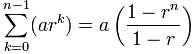

    where r = (1+rr) and a = m, the effective monthly installment payment over the actual life of the loan.
    
    assumption 2: when loan terminates early(due to default or pre-payment) total cash received
    + accrued interest are re-invested at the same rate rr from that time till the term of the loan

In [28]:
def calc_return(total_pymnt, term, funded_amnt, recoveries, realized_loan_term_mths, r=0.01):
    effective_monthly_installments = (total_pymnt - recoveries)/realized_loan_term_mths
    
    #get total cash flow at loan termination as the geometric sum of effective monthly installments
    #yielding a constant rate of return rr.
    #This is from assumption #1
    rr =r/12 #expecting r to be the annual yield
    total_cash_flow = effective_monthly_installments * ((1 - (1 + rr)**realized_loan_term_mths)) / (1 - (1 + rr))
    
    #add back recoveries to the get the lump sum at loan termination.
    total_cash_flow+= recoveries 

    #assumption #2. invest at rr till original term of loan.
    total_cash_flow = total_cash_flow * ((1 + rr)**(max(0,term - realized_loan_term_mths)))
    
    #calculate total return R and annualize
    R = (total_cash_flow - funded_amnt) / funded_amnt
    return ((1+R)**(12/term) - 1)


In [29]:
rr = 0.01
ret_df["annualized_returns"] = ret_df.apply(lambda row: calc_return(row[3], row[4], row[5], row[6], row[7], rr), axis =1)

In [32]:
ret_df.shape

(2249276, 9)

In [34]:
ret_df = ret_df.astype({'id': 'uint32'})


In [35]:
ret_df.sample(10)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,realized_loan_term_mths,annualized_returns
2201369,93959740,2016-11-01,2018-01-01,26675.211807,36,25000.0,0.00,14.0,0.029975
510994,126729784,2018-01-01,2019-01-01,9889.065760,36,9000.0,0.00,12.0,0.040388
1764941,9145023,2013-12-01,2014-09-01,11250.020000,60,32000.0,4284.61,9.0,-0.181403
11919,67705788,2015-12-01,2016-01-01,6011.220000,36,6000.0,0.00,1.0,0.010395
1738390,96562299,2017-01-01,2019-03-01,11797.560000,36,12000.0,0.00,26.0,0.000583
1654263,134737,2007-10-01,2007-12-01,530.580000,36,5000.0,214.22,2.0,-0.522035
2077483,125014016,2017-11-01,2019-02-01,8087.650000,60,24000.0,0.00,15.0,-0.188506
388969,39937907,2015-01-01,2016-06-01,22575.830004,36,19200.0,0.00,17.0,0.063419
1409770,143783235,2018-11-01,2019-03-01,2165.860000,60,30000.0,0.00,4.0,-0.403154
1456947,141319932,2018-10-01,2019-03-01,1572.800000,36,10000.0,0.00,5.0,-0.455242


In [36]:
def fit_return_models(X_train, Y_train, X_test, Y_test, model_name ="Ridge",
                      cv_parameters = {},
                      random_state = 1980):
    '''
    fits 2 return models using the sklearn model object implied by model name. One model for loans that defaulted and another for 
    loans that didn't default.
    code borrowed mostly from the danguetta.com paper/notebook.
    '''
    
    np.random.seed(random_state)
    
    #choose model based on user selection
    if model_name == "Lasso":
        model = linear_model.Lasso(normalize=True)
    elif model_name == "Ridge":
        model = linear_model.Ridge(normalize=True)
    elif model_name == "RandomF":
        model = RandomForestRegressor()

    
 
    #split data into defaulted series and non-defaulted series

    Y_train_bad = Y_train.loc[(Y_train._good == 0),['id', 'annualized_returns'] ]
    X_train_bad = X_train[X_train.id.isin(Y_train_bad.id)]
    Y_test_bad  = Y_test.loc[(Y_test._good == 0),['id', 'annualized_returns'] ]
    X_test_bad  = X_test[X_test.id.isin(Y_test_bad.id)]
    
    Y_train_good = Y_train.loc[(Y_train._good == 1),['id', 'annualized_returns'] ]
    X_train_good = X_train[X_train.id.isin(Y_train_good.id)]  
    Y_test_good  = Y_test.loc[(Y_test._good == 1),['id', 'annualized_returns'] ]
    X_test_good  = X_test[X_test.id.isin(Y_test_good.id)]

    
    ##remove ids for now to be added back afterwards
    train_bad_loan_ids = X_train_bad.pop('id')
    test_bad_loan_ids = pd.DataFrame(X_test_bad.pop('id'), columns=['id'])


    train_good_loan_ids = X_train_good.pop('id')
    test_good_loan_ids = pd.DataFrame(X_test_good.pop('id'), columns=['id'])
    

    
    ##drop ids from Y datasets
    Y_train_good.drop('id', axis =1, inplace=True)
    Y_train_bad.drop('id', axis=1, inplace=True)
    
    Y_test_good.drop('id', axis =1, inplace=True)
    Y_test_bad.drop('id', axis =1, inplace=True)
    

    
    ##run model
    cv_model_bad = GridSearchCV(model, cv_parameters, scoring='r2')
    cv_model_good = GridSearchCV(model, cv_parameters, scoring='r2')

    #time and fit the models
    start_time = time.time()
    print("fitting model for defaulted loans")
    if model_name in ['RandomF']:
        cv_model_bad.fit(X_train_bad, Y_train_bad.values.ravel())
    else:
        cv_model_bad.fit(X_train_bad, Y_train_bad)
        
    print("fitting model for non-defaulted loans")
    if model_name in ['RandomF']:
        cv_model_good.fit(X_train_good, Y_train_good.values.ravel())
    else:
        cv_model_good.fit(X_train_good, Y_train_good)
        
    end_time = time.time()

    #pick best model from the fit for each regressor
    best_model_bad = cv_model_bad.best_estimator_
    best_model_good = cv_model_good.best_estimator_
            
    #tidy outputs    
    print("=========================")
    print("  Model: " + model_name )
    print("=========================")

    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print("model_default:",cv_model_bad.best_params_, "model_non-default",cv_model_good.best_params_)

    ##predicted returns - need to join back to get loan ids
    predicted_non_default_return = pd.DataFrame(best_model_good.predict(X_test_good), columns =['ret'])
    predicted_default_return     = pd.DataFrame(best_model_bad.predict(X_test_bad), columns =['ret'])
    
    
    ## add ids back
    predicted_non_default_return = list(zip(test_good_loan_ids.id, predicted_non_default_return.ret))
    
    predicted_default_return = list(zip(test_bad_loan_ids.id, predicted_default_return.ret))
    
    print("")
    print("Testing r2 scores:")
    # Here we use different testing set to report the performance
    test_scores = {'model_default':r2_score(Y_test_bad,best_model_bad.predict(X_test_bad)),
                      'model_non_default':r2_score(Y_test_good,best_model_good.predict(X_test_good))}
 
    print("model_default:", test_scores['model_default'])
    print("model_non_default:", test_scores['model_non_default'])

    return { 'model_default':best_model_bad, 'model_non_default':best_model_good, 'predicted_non_default_return':predicted_non_default_return,
              'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

    
    


### Testing stuff


In [37]:
ret_df.head(2)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,realized_loan_term_mths,annualized_returns
0,68407277,2015-12-01,2019-01-01,4421.723917,36,3600.0,0.0,37.0,0.076315
1,68355089,2015-12-01,2016-06-01,25679.660000,36,24700.0,0.0,6.0,0.022233


In [38]:
my_X_train = X_train.copy()
my_Y_train = Y_train.copy()

my_X_test = X_test.copy()
my_Y_test = Y_test.copy()

In [39]:
#merge returns data
my_Y_train = pd.merge(my_Y_train, ret_df[['id','annualized_returns']], how="left", on ='id')
my_Y_test = pd.merge(my_Y_test, ret_df[['id','annualized_returns']], how="left", on ='id')


In [40]:
my_Y_test.isnull().sum(axis=0)

id                       0
_good                    0
annualized_returns    2253
dtype: int64

In [41]:
my_Y_train.dropna(inplace=True)
my_Y_test.dropna(inplace=True)

## Test regression models


### Ridge

In [43]:
cv_parameters = {'alpha': np.logspace(-8, 2, num = 10), 'max_iter' : [2000]}

reg_ridge = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="Ridge",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: Ridge
Fit time: 26.04 seconds
Optimal parameters:
model_default: {'alpha': 2.1544346900318867e-05, 'max_iter': 2000} model_non-default {'alpha': 1.6681005372000591e-06, 'max_iter': 2000}

Testing r2 scores:
model_default: 0.09609842763909493
model_non_default: 0.3688380393363825


In [44]:
list_ids, returns_non_defaults = zip(*reg_ridge['predicted_non_default_return'])
list_ids, returns_defaults = zip(*reg_ridge['predicted_default_return'])

actual_defaults  = my_Y_test.loc[(my_Y_test._good == 0),['annualized_returns']]
actual_non_defaults = my_Y_test.loc[(my_Y_test._good == 1),['annualized_returns']]


In [45]:
print("Means of various populations, actual vs. pred:")
print("-"*50)
print(f'actual_non_defaults:{np.mean(actual_non_defaults.annualized_returns):.4f}')
print(f'predicted_non_defaults:{np.mean(returns_non_defaults):.4f}')
print("\n")
print(f'actual_defaults:{np.mean(actual_defaults.annualized_returns):.4f}')
print(f'predicted_defaults:{np.mean(returns_defaults):.4f}')

Means of various populations, actual vs. pred:
--------------------------------------------------
actual_non_defaults:0.0506
predicted_non_defaults:0.0506


actual_defaults:-0.1729
predicted_defaults:-0.1727


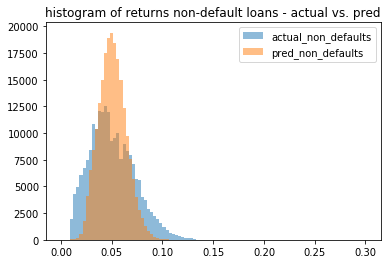

In [46]:
bins = np.linspace(-0., 0.3, 100)

pyplot.hist(actual_non_defaults.annualized_returns, bins, alpha=0.5, label='actual_non_defaults')

pyplot.hist(returns_non_defaults, bins, alpha=0.5, label='pred_non_defaults')

pyplot.legend(loc='upper right')
pyplot.title("histogram of returns non-default loans - actual vs. pred")
pyplot.show()

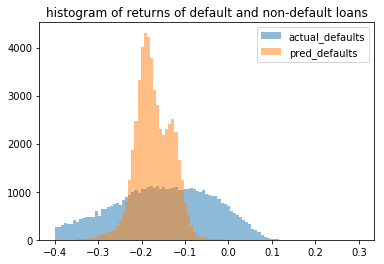

In [47]:
bins = np.linspace(-0.4, 0.3, 100)

pyplot.hist(actual_defaults.annualized_returns,  bins, alpha=0.5, label='actual_defaults')
pyplot.hist(returns_defaults,  bins, alpha=0.5, label='pred_defaults')
pyplot.legend(loc='upper right')
pyplot.title("histogram of returns of default and non-default loans")
pyplot.show()

In [48]:
np.sum(returns_non_defaults * actual_non_defaults.annualized_returns<0)

9

In [49]:
(np.sum(returns_non_defaults * actual_non_defaults.annualized_returns<0))/actual_non_defaults.shape[0]

4.214627567410626e-05

### Random Forest

In [50]:
#to be fine tuned...but too slow on my mac. took 2hours to run with these parameters!
cv_parameters = {'min_samples_leaf':[100],
                 'n_estimators': [100] }

reg_rf = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="RandomF",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: RandomF
Fit time: 6736.53 seconds
Optimal parameters:
model_default: {'min_samples_leaf': 100, 'n_estimators': 100} model_non-default {'min_samples_leaf': 100, 'n_estimators': 100}

Testing r2 scores:
model_default: 0.16036406197643482
model_non_default: 0.4859712775610434


In [51]:
my_Y_train.columns

Index(['id', '_good', 'annualized_returns'], dtype='object')

In [52]:
#### create risk data.
risk_data_train = pd.merge(my_X_train[['id', 'grade', 'sub_grade', 'term']], my_Y_train, how='inner', on='id')

In [53]:
risk_data_train.isnull().sum(axis=0)

id                    0
grade                 0
sub_grade             0
term                  0
_good                 0
annualized_returns    0
dtype: int64

In [54]:
##create risk scores

def var_95(ret):
    return np.percentile(ret,  5)

def var_99(ret):
    return np.percentile(ret, 1)

def ES_95(ret):
    threshold = var_95(ret)
    return np.mean(ret[ret < threshold])

def ES_99(ret):
    threshold = var_99(ret)
    return np.mean(ret[ret < threshold])



In [56]:
risk_summary_grades_all = pd.DataFrame(risk_data_train.groupby(['grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()



In [57]:
risk_summary_sub_grades_all = pd.DataFrame(risk_data_train.groupby(['sub_grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()


In [58]:
risk_summary_sub_grades_5yr = pd.DataFrame(risk_data_train.loc[(risk_data_train.term == 1)].groupby(['sub_grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()


In [59]:
risk_summary_sub_grades_3yr = pd.DataFrame(risk_data_train.loc[(risk_data_train.term == 0)].\
                                           groupby(['sub_grade'])['annualized_returns'].\
                                           agg(['count', 'median' , 'mean', 'min','max', 'std',\
                                           var_95, var_99, ES_95, ES_99])).reset_index()


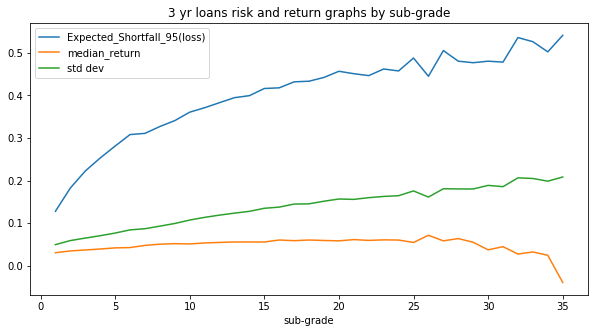

In [60]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, abs(risk_summary_sub_grades_3yr.ES_95))
pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, risk_summary_sub_grades_3yr['median'])
pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, risk_summary_sub_grades_3yr['std'])
#pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/abs(risk_summary_sub_grades_3yr.ES_95)))

pyplot.legend(['Expected_Shortfall_95(loss)', 'median_return', 'std dev'], loc='upper left')
pyplot.title('3 yr loans risk and return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

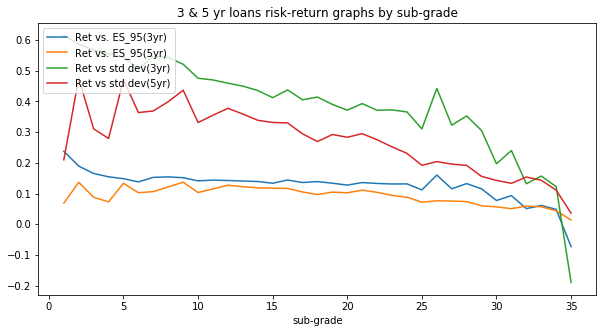

In [61]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/abs(risk_summary_sub_grades_3yr.ES_95)))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, (risk_summary_sub_grades_5yr['median']/abs(risk_summary_sub_grades_5yr.ES_95)))

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/risk_summary_sub_grades_3yr['std']))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, (risk_summary_sub_grades_5yr['median']/risk_summary_sub_grades_5yr['std']))

pyplot.legend(['Ret vs. ES_95(3yr)', 'Ret vs. ES_95(5yr)', 'Ret vs std dev(3yr)', 'Ret vs std dev(5yr)'], loc='upper left')
pyplot.title('3 & 5 yr loans risk-return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

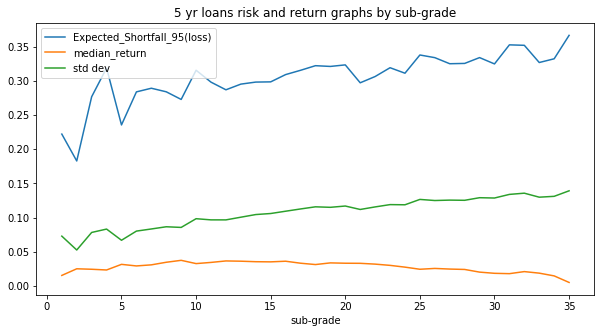

In [62]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, abs(risk_summary_sub_grades_5yr.ES_95))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, risk_summary_sub_grades_5yr['median'])
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, risk_summary_sub_grades_5yr['std'])

pyplot.legend(['Expected_Shortfall_95(loss)', 'median_return', 'std dev'], loc='upper left')
pyplot.title('5 yr loans risk and return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

In [63]:

##try some K-means clustering: do these clusters mean anything?
n_clusters = 5
my_X_train['cluster'] = 0

kmeans = KMeans(n_clusters=n_clusters, random_state=1980, verbose=0).fit(my_X_train.drop(['id','cluster'], axis=1))



In [64]:
my_X_train['cluster'] = kmeans.predict(my_X_train.drop(['id','cluster'], axis=1))


In [65]:
risk_data_train['cluster'] =0
risk_data_train = pd.merge(risk_data_train.drop('cluster', axis=1), my_X_train[['id','cluster']], how='left', on='id')

In [66]:
risk_data_train.columns

Index(['id', 'grade', 'sub_grade', 'term', '_good', 'annualized_returns',
       'cluster'],
      dtype='object')

In [67]:
risk_summary_clusters_all = pd.DataFrame(risk_data_train.groupby(['cluster'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()
risk_summary_clusters_all.sort_values('median')

,cluster,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
1,1,50,0.036385,-0.016211,-0.462233,0.078553,0.129427,-0.333319,-0.424300,-0.402577,-0.462233
3,3,52145,0.037987,0.011607,-0.693389,0.141969,0.098817,-0.228284,-0.405901,-0.337573,-0.492639
2,2,2409,0.038309,0.014952,-0.686887,0.131008,0.099629,-0.209834,-0.443489,-0.359313,-0.535073
0,0,347884,0.039347,0.008085,-0.921296,0.159925,0.102869,-0.237755,-0.404775,-0.338806,-0.484258
4,4,664558,0.043204,0.004383,-0.834690,0.160690,0.113807,-0.263372,-0.430535,-0.365357,-0.507192


In [68]:
risk_summary_grades_all.sort_values('median')

,grade,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
6,7,7206,0.018225,-0.045276,-0.663302,0.159153,0.147334,-0.318800,-0.442382,-0.401827,-0.524884
5,6,25422,0.028999,-0.024950,-0.797256,0.160690,0.139058,-0.290732,-0.429361,-0.377210,-0.506761
0,1,186727,0.034808,0.020314,-0.819906,0.079302,0.066032,-0.048840,-0.341043,-0.231734,-0.443174
4,5,74217,0.038948,-0.016533,-0.745056,0.141969,0.136494,-0.292777,-0.442430,-0.387008,-0.522714
1,2,311742,0.045962,0.016012,-0.908308,0.108635,0.093967,-0.214864,-0.396455,-0.327910,-0.480852
3,4,159043,0.048188,-0.007220,-0.921296,0.159925,0.134665,-0.304214,-0.464207,-0.400490,-0.536537
2,3,302689,0.048532,0.003030,-0.839784,0.144289,0.117306,-0.270609,-0.436392,-0.369379,-0.506276


In [369]:
useRidge = 0

#make predictions on the test sample using both models
if useRidge:
    pred_ret_if_non_defaulting = reg_ridge['model_non_default'].predict(my_X_test.drop('id', axis=1))[:,0]
    pred_ret_if_defaulting = reg_ridge['model_default'].predict(my_X_test.drop('id', axis=1))[:,0]
    regressor_used ="Ridge"
else:
    pred_ret_if_non_defaulting = reg_rf['model_non_default'].predict(my_X_test.drop('id', axis=1))
    pred_ret_if_defaulting = reg_rf['model_default'].predict(my_X_test.drop('id', axis=1))
    regressor_used ="Random Forest"

In [370]:
##combine the predicted returns from ridge regressor into a single dataframe to join with predicted default probs

pred_returns_good =pd.DataFrame({'id': my_X_test.id, 'pred_ret_good': pred_ret_if_non_defaulting })
pred_returns_bad =pd.DataFrame({'id': my_X_test.id.values, 'pred_ret_bad': pred_ret_if_defaulting})

combined_pred_returns = pd.merge(pred_returns_good, pred_returns_bad, how='inner', on='id')

In [371]:
def_predictions = pd.read_csv("data/predictions_random_1592421122.csv")

In [372]:
### add [grade, sub_grade, term] to def_predictions
#get subset from prediction df
LC_subset_df = LC_df[LC_df.id.isin(def_predictions.id)]
LC_subset_df = LC_subset_df.astype({'id': 'int64'})


In [373]:
def_predictions = pd.merge(def_predictions, LC_subset_df[['id','grade','sub_grade','term','loan_amnt','funded_amnt']], how ='inner', on='id')

In [374]:
##convert grade, sub_grade and term to numbers - from Dmitri's notebook
sub_grades = sorted(def_predictions.sub_grade.unique())
sub_grades_dict = {x:sub_grades.index(x)+1 for x in sub_grades}  # map 'A1' to 1 rather than 0

ordinal_dict = {
    'grade':   {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7},
    'sub_grade': sub_grades_dict,
    'term': {' 36 months':0, ' 60 months':1}
}

for f in ['grade', 'sub_grade','term']:
    def_predictions[f].replace(ordinal_dict[f], inplace=True)


In [375]:
def_predictions = pd.merge(def_predictions, combined_pred_returns, how="left", on='id')

In [376]:
def_predictions.sample(10)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt,pred_ret_good,pred_ret_bad
44920,8560098,1,0.922278,1,4,0,10000.0,10000.0,0.041472,-0.170415
215007,76436145,0,0.787949,2,7,0,4200.0,4200.0,0.045587,-0.161330
209548,100157977,1,0.907180,2,10,0,22000.0,22000.0,0.042325,-0.206339
45327,124988575,0,0.931027,2,6,0,10200.0,10200.0,0.030745,-0.314241
125543,21260308,1,0.625230,4,20,1,25000.0,25000.0,0.060800,-0.110212
252949,14478018,1,0.628062,6,28,0,8125.0,8125.0,0.101842,-0.189094
141527,1276099,1,0.864754,4,17,0,10000.0,10000.0,0.058103,-0.219896
206998,74615964,1,0.905892,2,7,0,4000.0,4000.0,0.041975,-0.155500
86888,3147145,0,0.778692,3,13,0,10500.0,10500.0,0.078586,-0.158540
3916,51997988,1,0.642886,4,16,1,28000.0,28000.0,0.052959,-0.113470


In [377]:
def calc_expected_ret(good, p, pred_ret_good, pred_ret_bad):
    if good:
        return (p * pred_ret_good) + ((1-p) * pred_ret_bad)
    else:
        return (p * pred_ret_bad)  + ((1-p) * pred_ret_good)

In [378]:
#calc expected returns
def_predictions['pred_expected_ret'] = def_predictions.apply(lambda row: calc_expected_ret(row._good, \
                                                                        row.p, row.pred_ret_good, row.pred_ret_bad), axis=1)

In [379]:
def_predictions.sample(10)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt,pred_ret_good,pred_ret_bad,pred_expected_ret
12534,132745288,1,0.841099,4,19,0,15000.0,15000.0,0.045191,-0.290685,-0.008180
261129,20849342,1,0.880151,2,7,0,8000.0,8000.0,0.048873,-0.151782,0.024824
71439,30776043,1,0.759840,3,13,1,23575.0,23575.0,0.055815,-0.104360,0.017347
191599,20702736,1,0.671618,4,19,0,11500.0,11500.0,0.077534,-0.178361,-0.006497
101503,45944205,1,0.873783,2,6,0,13000.0,13000.0,0.041114,-0.166161,0.014952
103050,26229620,1,0.907538,2,6,0,30000.0,30000.0,0.046760,-0.178020,0.025976
10834,30315150,0,0.736018,5,21,0,9575.0,9575.0,0.089414,-0.171412,-0.102559
152838,87384249,1,0.930546,2,7,0,2000.0,2000.0,0.040311,-0.229573,0.021566
5350,42495381,0,0.746901,3,14,0,25000.0,25000.0,0.061948,-0.178403,-0.117570
91576,657107,1,0.832148,2,10,1,4000.0,4000.0,0.049241,-0.116082,0.021491


In [380]:
##choose std_dev and ES_95 as risk measures

def_predictions['risk_std_dev'] =0
def_predictions['risk_ES_95'] = 0


In [381]:
print(risk_summary_sub_grades_3yr.shape)
print(risk_summary_sub_grades_5yr.shape)

(35, 11)
(35, 11)


In [382]:
sub_grades = risk_summary_sub_grades_3yr.sub_grade.unique()


In [383]:
for sg in sub_grades:
    pred_std_dev_3yr = float(risk_summary_sub_grades_3yr[risk_summary_sub_grades_3yr.sub_grade == sg]['std'].values)
    pred_std_dev_5yr = float(risk_summary_sub_grades_5yr[risk_summary_sub_grades_5yr.sub_grade == sg]['std'].values)

    pred_ES_95_3yr = float(risk_summary_sub_grades_3yr[risk_summary_sub_grades_3yr.sub_grade == sg]['ES_95'].values)
    pred_ES_95_5yr = float(risk_summary_sub_grades_5yr[risk_summary_sub_grades_5yr.sub_grade == sg]['ES_95'].values)
    
    def_predictions.loc[(def_predictions['term'] == 0) & (def_predictions.sub_grade == sg) ,'risk_std_dev'] = pred_std_dev_3yr
    def_predictions.loc[(def_predictions['term'] == 1) & (def_predictions.sub_grade == sg),'risk_std_dev']  = pred_std_dev_5yr

    def_predictions.loc[(def_predictions['term'] == 0) & (def_predictions.sub_grade == sg),'risk_ES_95'] = pred_ES_95_3yr
    def_predictions.loc[(def_predictions['term'] == 1) & (def_predictions.sub_grade == sg),'risk_ES_95'] = pred_ES_95_5yr

    
    

In [384]:
def_predictions.columns

Index(['id', '_good', 'p', 'grade', 'sub_grade', 'term', 'loan_amnt',
       'funded_amnt', 'pred_ret_good', 'pred_ret_bad', 'pred_expected_ret',
       'risk_std_dev', 'risk_ES_95'],
      dtype='object')

In [385]:
def neg_risk_penalized_ret(notionals, pred_ret, risk, lambda_c):
    risk_adj_ret = pred_ret - (lambda_c * np.abs(risk))
    neg_ret = -1 * sum([x[0]*x[1] for x in zip(notionals, risk_adj_ret)])
    #print("Iterating:", neg_ret)
    return neg_ret



def portfolio_optimize(pred_ret,  funded_amts, budget = 1e6, lambda_c = 0.01, risk_measure = 1, risk_std=[], risk_ES=[]):
    '''
    risk can be either standard deviations or Expected Shortfall. Expected Shortfall is reported as negative
    so take the abs of the quantities there.
    risk_measure={0:standard deviation, 1:Expected shortfall}
    '''    
    if risk_measure:
        risk = risk_ES
    else:
        risk = risk_std
    
    assert(len(pred_ret) == len(risk) == len(funded_amts))

    init_notionals = [budget/len(pred_ret)] * len(pred_ret) #initialize variables
    arguments = (pred_ret, risk, lambda_c) #arguments into the objective function other than the variables
    
    linear_constraint = LinearConstraint(np.ones(len(init_notionals)), lb=0, ub=budget)  #total investment<=budget
    
    var_bounds = [(0, funded_amts[i]) for i in range(len(funded_amts))]
    
    opt_portfolio = minimize(neg_risk_penalized_ret, init_notionals,
                             args=arguments,
                             constraints=linear_constraint,
                             bounds=var_bounds,
                             method='SLSQP',
                             options={'ftol': 1e-5, 'disp': True, 'maxiter': 2000 }
                            )
    return opt_portfolio




## Test optimal portfolios


### seed with top n loans sorted by predicted expected returns


In [343]:
n =100
risk_aversion = 0.001

In [344]:
top_by_expected_ret = (def_predictions[['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]

In [345]:
def calc_realized_returns(optimal_portf):
    '''
    join with the returns dataframe to get the realized returns for each selected loan
    
    '''
    optimal_portf = pd.merge(optimal_portf, ret_df[['id','annualized_returns']], how='left', on='id')
    optimal_portf.annualized_returns.fillna(0, inplace=True)
    assert(len(optimal_portf.optimal_notionals) ==  len(optimal_portf.annualized_returns))
    num = np.sum([x[0]*x[1] for x in zip(optimal_portf.optimal_notionals, optimal_portf.annualized_returns)])
    den = np.sum(optimal_portf.optimal_notionals)
    return(num/den)

In [346]:
def get_optimized_portfolios(id_values, ret, funded_amnt, risk_aversion, risk_measure, risk):
    start_time = time.time()
    if risk_measure:
        opt_expected_ret_ES = portfolio_optimize(ret,
                                          funded_amnt, lambda_c = risk_aversion, \
                                          risk_measure = risk_measure, risk_ES=risk
                                         )
    else:
        opt_expected_ret_ES = portfolio_optimize(ret,
                                          funded_amnt, lambda_c = risk_aversion, \
                                          risk_measure = risk_measure, risk_std=risk
                                         )
    end_time = time.time()
    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Risk aversion parameter:", risk_aversion)
    
    opt_df = pd.DataFrame({'id':id_values, 'funded_amnt': funded_amnt, \
                  'optimal_notionals':opt_expected_ret_ES.x})
    opt_df.optimal_notionals = opt_df.optimal_notionals.apply(lambda val: round(val))
    return opt_df

In [347]:
lambda_c =[0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000001, 0]

In [348]:
#find the optimal risk_aversion parameter:
portf_ret_arr = [calc_realized_returns(get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_expected_ret.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion_parameter, 0,
                                                                top_by_expected_ret.risk_std_dev))\
 for risk_aversion_parameter in lambda_c]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69314.53977994826
            Iterations: 109
            Function evaluations: 11129
            Gradient evaluations: 109
Fit time: 2.92 seconds
Risk aversion parameter: 0.01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70900.221756408
            Iterations: 279
            Function evaluations: 28367
            Gradient evaluations: 278
Fit time: 7.42 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71022.5615304557
            Iterations: 167
            Function evaluations: 17045
            Gradient evaluations: 167
Fit time: 4.45 seconds
Risk aversion parameter: 0.001
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72279.78840198659
            Iterations: 867
            Function evaluations: 88056
            Grad

In [349]:
print("N=",n)
print("Regression algo:", regressor_used)
print("risk measure: Std dev")
pd.DataFrame({'lambda': lambda_c, 'max_returns':portf_ret_arr}).sort_values('max_returns', ascending=False)

N= 100
Regression algo: Ridge
risk measure: Std dev


,lambda,max_returns
0,0.010000,0.077352
2,0.001000,0.076821
1,0.005000,0.076610
4,0.000100,0.076161
5,0.000050,0.076101
7,0.000001,0.076098
3,0.000500,0.075931
8,0.000000,0.075858
6,0.000010,0.075823


In [325]:
print("N=",n)
print("Regression algo:", regressor_used)
print("risk measure: Std dev")
pd.DataFrame({'lambda': lambda_c, 'max_returns':portf_ret_arr}).sort_values('max_returns', ascending=False)

N= 100
Regression algo: Random Forest
risk measure: Std dev


,lambda,max_returns
4,0.000100,0.084724
6,0.000010,0.084457
3,0.000500,0.084438
8,0.000000,0.083792
2,0.001000,0.083752
1,0.005000,0.083619
7,0.000001,0.083607
5,0.000050,0.083562
0,0.010000,0.083439


### seed with top n loans sorted by predicted expected returns


In [412]:
n= 100
risk_aversion =0.01
print(regressor_used)

Random Forest


In [413]:
top_by_expected_ret = (def_predictions[['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]

#### risk measure = expected shortfall


In [414]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_expected_ret.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_1 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_1.optimal_notionals = opt_df_1.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -53438.22824476313
            Iterations: 486
            Function evaluations: 49389
            Gradient evaluations: 484
Fit time: 4.12 seconds


#### risk measure = standard deviation


In [415]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_expected_ret.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_2 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_2.optimal_notionals = opt_df_2.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -55719.355809851775
            Iterations: 500
            Function evaluations: 50877
            Gradient evaluations: 498
Fit time: 14.12 seconds


### seed with top n loans sorted by predicted non_default returns


In [416]:
top_by_expected_ret = (def_predictions[['id','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_ret_good', ascending=False)).iloc[:n,]

#### risk measure = expected shortfall


In [417]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_3 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_3.optimal_notionals = opt_df_3.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72495.76881678164
            Iterations: 76
            Function evaluations: 7752
            Gradient evaluations: 76
Fit time: 0.77 seconds


#### risk measure = standard deviation


In [418]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_4 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_4.optimal_notionals = opt_df_4.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -74577.28875287308
            Iterations: 76
            Function evaluations: 7752
            Gradient evaluations: 76
Fit time: 2.41 seconds


### seed with top n loans sorted by returns with highest probability of non-default


In [419]:
top_by_expected_ret = (def_predictions.loc[(def_predictions._good == 1),['id', '_good', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('p', ascending=False)).iloc[:n,]

#### risk measure = expected shortfall


In [420]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_5 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_5.optimal_notionals = opt_df_5.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -24629.091724994305
            Iterations: 252
            Function evaluations: 25602
            Gradient evaluations: 251
Fit time: 2.35 seconds


#### risk measure = standard deviation


In [421]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_6 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_6.optimal_notionals = opt_df_6.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -25499.6719343228
            Iterations: 190
            Function evaluations: 19380
            Gradient evaluations: 190
Fit time: 5.55 seconds


In [422]:
def_predictions.grade.value_counts()

2    76344
3    74343
1    45651
4    39399
5    18285
6     6194
7     1771
Name: grade, dtype: int64

### seed with top n loans selected randomly


In [423]:
top_by_expected_ret = def_predictions[['id', '_good','grade', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                       iloc[(np.random.randint(0,def_predictions.shape[0],n)),:]
                       

#### risk measure = expected shortfall


In [424]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_7 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_7.optimal_notionals = opt_df_7.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -51499.52699009238
            Iterations: 960
            Function evaluations: 97512
            Gradient evaluations: 956
Fit time: 8.84 seconds


#### risk measure = standard deviation


In [425]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_8 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_8.optimal_notionals = opt_df_8.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -53782.84740986625
            Iterations: 1098
            Function evaluations: 111609
            Gradient evaluations: 1094
Fit time: 31.21 seconds


### calculate realized returns of the 6 portfolios


In [426]:
##generate simple annualized returns -- don't kill me Simon!
opt_portf_arr = [opt_df_1, opt_df_2, opt_df_3, opt_df_4, opt_df_5, opt_df_6, opt_df_7, opt_df_8]
simple_ret_arr = [calc_realized_returns(portf) for portf in opt_portf_arr]

In [427]:

strategy =['expected_ret_ES', 'expected_ret_STDDEV',\
           'non_default_scenario_ret_ES', 'non_default_scenario_ret_STDDEV',\
           'non_default_prob_ret_ES', 'non_default_prob_ret_STDDEV', 'random_ES', 'random_STDDEV']
resultset = pd.DataFrame({'Selection_criteria': strategy, 'Actual_realized_returns':simple_ret_arr}).\
                sort_values('Actual_realized_returns', ascending=False)

In [428]:
print("Risk aversion parameter:", risk_aversion, "\nRegressor:", regressor_used)
resultset

Risk aversion parameter: 0.01 
Regressor: Random Forest


,Selection_criteria,Actual_realized_returns
0,expected_ret_ES,0.083555
1,expected_ret_STDDEV,0.083439
4,non_default_prob_ret_ES,0.027802
5,non_default_prob_ret_STDDEV,0.027802
6,random_ES,-0.004566
7,random_STDDEV,-0.004699
2,non_default_scenario_ret_ES,-0.012114
3,non_default_scenario_ret_STDDEV,-0.012114


In [366]:
print("Risk aversion parameter:", risk_aversion, "\nRegressor:", regressor_used)
resultset

Risk aversion parameter: 0.01 
Regressor: Ridge


,Selection_criteria,Actual_realized_returns
1,expected_ret_STDDEV,0.077352
0,expected_ret_ES,0.075777
4,non_default_prob_ret_ES,0.027802
5,non_default_prob_ret_STDDEV,0.027802
6,random_ES,0.020551
2,non_default_scenario_ret_ES,0.019593
3,non_default_scenario_ret_STDDEV,0.016437
7,random_STDDEV,0.014721


In [429]:
#best_portf_RF = opt_df_1

In [368]:
#best_portf_Ridge = opt_df_2

In [430]:
best_portf_Ridge['weights'] = best_portf_Ridge.optimal_notionals/best_portf_Ridge.optimal_notionals.sum()

In [431]:
best_portf_RF['weights'] = best_portf_RF.optimal_notionals/best_portf_RF.optimal_notionals.sum()

In [436]:
##send cut to Simon
best_portf_Ridge[['id', 'weights']].to_csv('optimal_weights_ridge.csv',index=False)
best_portf_RF[['id', 'weights']].to_csv('optimal_weights_randomF.csv',index=False)


In [435]:
best_portf_Ridge.sample(10)

,id,funded_amnt,optimal_notionals,weights
144136,569037,15000.0,8533,0.008533
249811,610365,12800.0,10878,0.010878
227774,431602,18000.0,10712,0.010712
58068,395514,5500.0,1845,0.001845
225641,578793,3000.0,2961,0.002961
216650,553121,25000.0,19471,0.019471
47293,635360,15000.0,8465,0.008465
26714,374485,14000.0,14000,0.014000
9635,424783,7500.0,3967,0.003967
53087,657924,14000.0,13578,0.013578
